In [8]:
# 100개
import os 
import requests
import pandas as pd

API_KEY = os.getenv("TMDB_API_KEY", "981245faa8d227df3246bc1b0ccc25dd")
NOW_LANG = "ko-KR"
# PAGE = 1
GENRE_LANG = "ko"
POSTER_BASE = "https://image.tmdb.org/t/p/w500" 
BACKDROP_BASE = "https://image.tmdb.org/t/p/w780" # 바탕화면이라 w780으로 고정!

# genres 데이터 적용하기
def genre_ids_to_names(ids, genre_map: dict) -> str :
    # [28, 53, 80] -> '액션|스릴러|범죄'

    if not isinstance(ids, list) :
        return ""

    names = [genre_map.get(i, str(i)) for i in ids] # ["액션", "스릴러", "범죄"]
    return "|".join(names) # '액션|스릴러|범죄'

# 텍스트 개행 수정 함수
def clean_one_line(text: str) -> str :
    if not text : 
        return ""
    text = text.replace("\n", " ")
    return " ".join(text.split())

# genres 데이터 가져오기
def fetch_genre_map(api_key: str, language: str = "ko") -> dict :
    url = "https://api.themoviedb.org/3/genre/movie/list"
    params = {"api_key": api_key, "language": language}
    res = requests.get(url, params=params, timeout=20)
    res.raise_for_status()

    genres = res.json().get("genres", [])
    return {g["id"] : g["name"] for g in genres} # {28 : "액션", 12: "모험", ...}

# genres 값 찾아오기
genre_map = fetch_genre_map(API_KEY, GENRE_LANG)

# now playing 데이터 가져오기
url = "https://api.themoviedb.org/3/movie/now_playing"
rows = []

for page in range(1, 6) :
    params = {"api_key": API_KEY, "language": NOW_LANG, "page": page}

    res = requests.get(url, params=params, timeout=20)
    res.raise_for_status()
   
    data = res.json()


    for m in data.get("results", []) :
        poster_path = m.get("poster_path")
        backdrop_path = m.get("backdrop_path")

        poster_url = f"{POSTER_BASE}{poster_path}" if poster_path else ""
        backdrop_url = f"{BACKDROP_BASE}{backdrop_path}" if backdrop_path else ""

        genre_ids = m.get("genre_ids", [])

        rows.append({
            "id": m.get("id"),
            "title": m.get("title"),
            "original_title": m.get("original_title"),
            "overview": clean_one_line(m.get("overview")),
            "genre_ids":  ",".join(map(str, genre_ids)) if isinstance(genre_ids, list) else "",
            "genre_names": genre_ids_to_names(genre_ids, genre_map),
            "adult": m.get("adult"),
            "original_language": m.get("original_language"),
            "vote_average": m.get("vote_average"),
            "popularity": m.get("popularity"),
            "vote_count": m.get("vote_count"),
            "poster_url": poster_url,
            "backdrop_url": backdrop_url
        })

df = pd.DataFrame(rows, columns=[
    "id",
    "title",
    "original_title",
    "overview",
    "genre_ids",
    "genre_names",
    "adult",
    "original_language",
    "vote_average",
    "popularity",
    "vote_count",
    "poster_url",
    "backdrop_url"
])
out_path = "tmdb_now_playing.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"✅ 저장완료 : {out_path} (rows={len(df)})")

df.head()
# """

✅ 저장완료 : tmdb_now_playing.csv (rows=100)


,id,title,original_title,overview,genre_ids,genre_names,adult,original_language,vote_average,popularity,vote_count,poster_url,backdrop_url
0,1306368,더 립,The Rip,허름한 은닉처에서 수백만 달러의 현금을 발견한 마이애미 경찰. 신뢰에 금이 가기 시...,"28,53,80",액션|스릴러|범죄,False,en,7.049,300.7556,860,https://image.tmdb.org/t/p/w500/o0d6Us9VWOW0nH...,https://image.tmdb.org/t/p/w780/3F2EXWF1thX0Bd...
1,1043197,더스트 바니,Dust Bunny,“어른도 아이도 함께하는 몬스터 사냥 이야기” 열 살 소녀 오로라는 침대 밑에 숨어...,"28,14,53",액션|판타지|스릴러,False,en,6.600,239.2488,128,https://image.tmdb.org/t/p/w500/vobigFZFvbYPf6...,https://image.tmdb.org/t/p/w780/AecGG1XVCmkk7f...
2,1419406,포풍추영,捕风追影,"첨단 감시 시스템과 삼엄한 보안망을 무력화하고, 수십억을 탈취한 정체불명의 범죄 조...","28,80,18,53",액션|범죄|드라마|스릴러,False,zh,7.213,363.8111,350,https://image.tmdb.org/t/p/w500/pUCkdO40PWHdvU...,https://image.tmdb.org/t/p/w780/4BtL2vvEufDXDP...
3,83533,아바타: 불과 재,Avatar: Fire and Ash,"인간들과의 전쟁으로 첫째 아들 ‘네테이얌’을 잃은 후, ‘제이크’와 ‘네이티리’는 ...","878,12,14",SF|모험|판타지,False,en,7.304,222.7451,1637,https://image.tmdb.org/t/p/w500/l18o0AK18KS118...,https://image.tmdb.org/t/p/w780/3Dqievkc7krcTt...
4,991494,스폰지밥 무비: 네모바지를 찾아서,The SpongeBob Movie: Search for SquarePants,비키니시티에 사는 스폰지밥은 무시무시한 롤러코스터를 탈 수 있는 용감한 ‘빅 가이’...,"16,10751,35,12,14",애니메이션|가족|코미디|모험|판타지,False,en,6.600,167.3536,138,https://image.tmdb.org/t/p/w500/2QCGC4toQXYuIs...,https://image.tmdb.org/t/p/w780/gbjK8p5S1aLXWC...


In [11]:
import pandas as pd 

CSV_PATH = "tmdb_now_playing.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

number_cols = ["vote_average", "popularity", "vote_count"]

for c in number_cols :
    if c in df.columns :
        df[c] = pd.to_numeric(df[c], errors="coerce")

def split_genres(x : str) :
    x = "" if pd.isna(x) else str(x).strip()
  # is : true? false?, na(not available) : 사용할 수 없는 값 = 결측값 = null not set undefined 
    if not x : 
        return []
    if "|" in x :
        parts = [p.strip() for p in x.split("|")]
    else :
        parts = [p.strip() for p in x.split(",")]
    return [p for p in parts if p] # ["범죄" "액션" "스릴러"]

df_g = df.copy()
df_g["genre"] = df_g["genre_names"].apply(split_genres)
df_g = df_g.explode("genre")

agg = (
    df_g.groupby("genre", as_index=False)
        .agg(
             movie_count=("id", "nunique"),
             avg_popularity=("popularity", "mean"),
             avg_vote_average=("vote_average", "mean"),
             avg_vote_count=("vote_count", "mean"),
        )
)

agg
# agg(aggregation) : 집계
# 시각화 = 차트 | 도표
# 데이터 => 수치화 (숫자)
# 남, 여 => 남 = 0, 여 = 1
# 10대, 20대, 30대, 40대, 50대 => 10대 = 0, 20대 = 1

,genre,movie_count,avg_popularity,avg_vote_average,avg_vote_count
0,SF,18,62.312006,6.455556,2361.166667
1,가족,6,55.081367,7.289167,3480.000000
2,공포,22,47.689523,6.170318,1663.500000
3,다큐멘터리,2,13.917800,8.117000,18.000000
4,드라마,38,38.168379,6.278079,1819.789474
5,로맨스,15,20.005000,6.656200,1080.200000
6,모험,14,87.324386,7.310643,10046.214286
7,미스터리,8,83.467250,6.388625,1314.375000
8,범죄,16,82.853306,6.680750,482.312500
9,스릴러,34,77.045147,6.729500,1583.117647


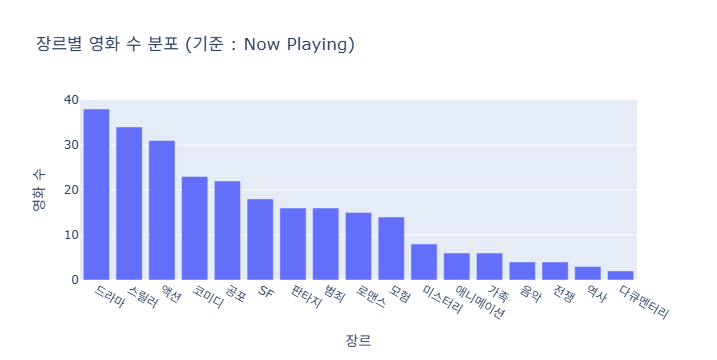

In [12]:
import plotly.express as px

fig = px.bar(
    agg.sort_values("movie_count", ascending=False),
    x="genre", 
    y="movie_count",
    title ="장르별 영화 수 분포 (기준 : Now Playing)"
)

fig.update_layout(xaxis_title="장르", yaxis_title="영화 수")
fig.show()

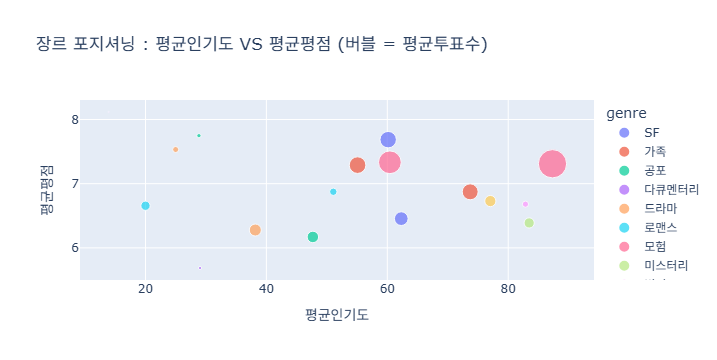

In [13]:
# 어떤 장르가 인기가 많을까?

import plotly.express as px

fig = px.scatter(
    agg,
    x="avg_popularity", 
    y="avg_vote_average",
    hover_name = "genre",
    color= "genre",
    size= "avg_vote_count",
    title="장르 포지셔닝 : 평균인기도 VS 평균평점 (버블 = 평균투표수)"
)
fig.update_layout(xaxis_title="평균인기도", yaxis_title="평균평점")
fig.show()

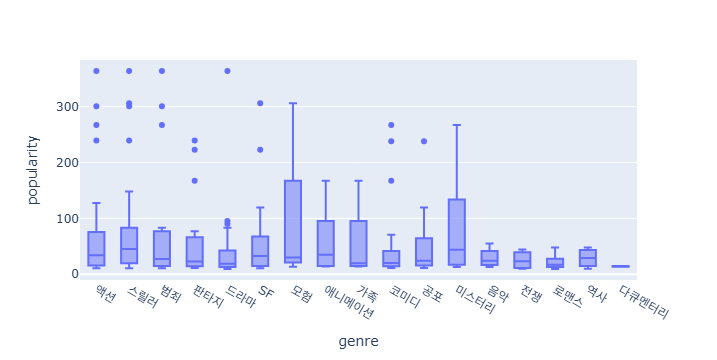

In [14]:
import plotly.express as px

fig = px.box(
    df_g,
    x="genre",
    y="popularity",
)

fig.show()

- [12, 15, 18, 20, 22, 25, 30, 35, 40, 100]
- 일반적으로 데이터를 분석할 때, 평균을 사용하기도 하지만 중앙(간)값 = 물리적인 가운데 값
- 짝수 / 홀수
- 짝수 일 때 = 중간 값 두개 더한 평균
- 홀수 일 때 = 그 가운데 1개 값
- median = (22 + 25) / 2 = 23.5
- 하위 50% = 12, 15, 18, 20, 22
   - 하위 50% 의 중앙값 = 1사분위 = Q1 = 18 (하위 25%)
- 상위 50% = 25, 30, 35, 40, 100
   - 상위 50% 의 중앙값 = 3사분위 = Q3 = 35 (상위 25%)
- IQR = InterQuartile Range = 중앙값 기준 퍼짐 정도
   - Q3 - Q1 = 35 - 18 = 17
- Lower Fence : 하한치 = Q1 - IQR X 1.5  = 18 - (17 * 1.5) = 18 - 25.5 = -7.5
- Upper Fence : 상한치 = Q3 + IQR X 1.5 = 35 + (17 * 1.5) = 35 + 25.5 = 60.5
- min = 12
- max = 40 (100이 될 수 없는 것은 상한치 보다 높기 때문!!)
- 이상치 = 100 = Outlier
- mean = (12 + 15 + 18 + 20 + 22 + 30 + 35 + 40 + 100) / 10 => 평균 = 31.7
- 편차 = 평균에서의 차이 12 - 31.7 = 19.7 / -16.7 / -13.7 ~~~~~ 68.3
- 음.양 x 평균으로 부터 대체적으로 얼만큼 떨어져 있느냐?
- 표준편차 = 모든 편차의 평균
- 제곱편차 = 388.09 / 278.89 / 187.69 ~~~~ 4664.89 => 5878.10
- 제곱편차 / n (10) = 모(집단)분산 = 587.81 => 10개라는 데이터가 확실하게 고정
- 제곱편차 / n - 1 (9) = 표(본)분산 = 653.12 => 1000만개 -> 과소추정법칙
- r 587.81 = 24.24 # r 루트
- r 653.12 = 25.55

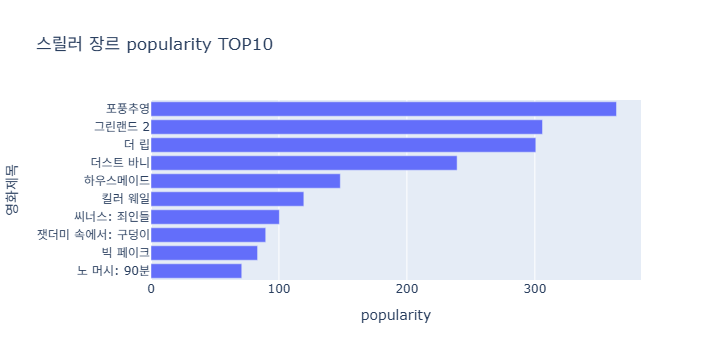

In [15]:
TARGET_GENRE = "스릴러"
TOP_N = 10

tmp = df_g[df_g["genre"] == TARGET_GENRE].copy()
tmp = tmp.dropna(subset=["popularity"])
tmp = tmp.sort_values("popularity", ascending=False).head(TOP_N)

fig = px.bar(
    tmp.sort_values("popularity"),
    x = "popularity",
    y = "title",
    hover_data=["vote_average", "vote_count", "original_language"],
    title=f"{TARGET_GENRE} 장르 popularity TOP{TOP_N}"
)

fig.update_layout(xaxis_title = "popularity", yaxis_title = "영화제목")
fig.show()

In [ ]:
# 히트맵 차트 : 색상 사용정도 분류 : 색상 진해지면, 색상 연해지면
# 상관관계 : 피어슨 상관계수 -> 공분산, 표준편차, 분산
